# Optimization

In [9]:
import modules
from modules import Aqua_Obj
import optimization
import copy
import numpy as np
import importlib
importlib.reload(modules)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

max_iter = 2000

def print_bold(str):
    print('\033[1m' + str + '\033[0;0m')
    return

def print_objective(title, aqua_obj):
    print_bold(title+" objective function terms:")
    print(' '*2, "cost_per_yield", "{:10.3f}".format(aqua_obj.cost_per_yield), '[$/kg]')
    print(' '*2, "price         ", "{:10.3f}".format(aqua_obj.price), '[$]')
    print(' '*2, "fish_yield    ", "{:10.3f}".format(aqua_obj.fish_yield), '[kg]')
    print("-"*40)

def print_price_breakdown(title, aqua_obj):
    print_bold(title+" price break down:")
    print(' '*2, "wec price      ", "{:10.3f}".format(aqua_obj.wec.price), '[$]')
    print(' '*2, "pen price      ", "{:10.3f}".format(aqua_obj.pen.price), '[$]')
    print(' '*2, "fish feed price", "{:10.3f}".format(aqua_obj.fish_feed_price), '[$]')
    print("-"*40)
    
def print_P_rated(title, aqua_obj):
    print_bold(title+" WEC rated power:")
    print(' '*2, "P_rated     ", "{:10.3f}".format(aqua_obj.P_rated/1000), '[kW]')
    print("-"*40)

def print_carrying_capacity(title, aqua_obj):
    print_bold(title+" carrying capacity:")
    print(' '*2, "TPF_O2              ", "{:10.3f}".format(aqua_obj.pen.TPF_O2), '[kg fish/year]')
    print(' '*2, "Carrying Capacity   ", "{:10.3f}".format(aqua_obj.carrying_capacity), '[kg fish]')
    print("-"*40)
    
def print_ineq_cons(title,aqua_obj):
    print_bold(title+" constraints:")
    print(' '*2, "P_gen_cons          ", "{:10.3f}".format(aqua_obj.P_gen_cons), '[kWh]')
    print(' '*2, "fish_yield_cons     ", "{:10.3f}".format(aqua_obj.fish_yield_cons), '[kg]')
    print(' '*2, "env_Umin_cons       ", "{:10.3f}".format(aqua_obj.env_Umin_cons), '[m/s]')
    print(' '*2, "env_Umax_cons       ", "{:10.3f}".format(aqua_obj.env_Umax_cons), '[m/s]')
    print(' '*2, "env_tempmin_cons    ", "{:10.3f}".format(aqua_obj.env_tempmin_cons), '[C]')
    print(' '*2, "env_tempmax_cons    ", "{:10.3f}".format(aqua_obj.env_tempmax_cons), '[C]')
    print(' '*2, "env_salinitymin_cons", "{:10.3f}".format(aqua_obj.env_salinitymin_cons), '[PSU]')
    print(' '*2, "env_salinitymax_cons", "{:10.3f}".format(aqua_obj.env_salinitymax_cons), '[PSU]')
    print(' '*2, "env_O2_min_cons     ", "{:10.3f}".format(aqua_obj.env_O2_min_cons), '[mg/l]')
    print("-"*40)
            
def optimize_result(x_name, x_list, x_unit, res_opt, p):
    aqua_opt_obj = Aqua_Obj(res_opt.x, x_name, p) 
    
    col_width = len(max(x_list, key=len))
    print(res_opt.success)
    print_bold("optimal design variable:")
    for i in range(len(x_list)):
        print(' '*2, x_list[i], ' '*(col_width - len(x_list[i])) , "{:10.3f}".format(res_opt.x[i]), x_unit[i])
    
    print(' '*2, "num_pens      ", "{:10.3f}".format(aqua_opt_obj.pen.n), '[-]')
    print("-"*40)
    
    print_P_rated("optimal",aqua_opt_obj)
    print_objective("optimal",aqua_opt_obj)
    print_price_breakdown("optimal",aqua_opt_obj)
    print_ineq_cons("optimal",aqua_opt_obj)
    print_carrying_capacity("optimal",aqua_opt_obj)
    
    
# fill default parameters
all_vars = ['x_wec','x_type_wec','x_pen', 'x_disc_pen', 'p_pen','x_env','p_wec','p_fish_salmon']

wec_types = ['point absorber'] #,'attenuator','terminator','point absorber']

# design variables
x_name = ['x_wec','x_pen']
x_list, x0_val, x_unit, x_bnds, x_label = optimization.default_value(x_name)
x0 = []
for i in range(len(x_list)):
    x0.append(x0_val[x_list[i]])

x_disc_name = ['x_disc_pen']
x_disc_list, x0_disc_val, x_disc_unit, x_disc_bnds, x_disc_label = optimization.default_value(x_disc_name)

# parameters
param_name = ['x_type_wec','x_disc_pen','x_env']
param_val = {}

param_val['temp'] =     16  #'C'
param_val['salinity'] = 33  #'[PSU]'
param_val['U'] =        0.2 #'[m/s]'
param_val['O2_in'] =    8   #'[mg/l]'
param_val['wave_height'] = 1.4  #'[m]'     
param_val['wave_period'] = 8.33 #'[s]' 

#optimization
res={}
res_best = {}
init_flag = 1

for i in range(len(wec_types)):
    param_val['wec_type'] = wec_types[i]
    for j0 in range(len(x_disc_list)):
        lower_bnd, upper_bnd = x_disc_bnds[j0]
        for j1 in range(lower_bnd,upper_bnd+1):
            param_val[x_disc_list[j0]] = j1            
                
            p_list, p, p_unit, p_bnds, p_label = optimization.argument_fun(x_name, param_name, param_val, all_vars)

            if init_flag:
                aqua_init_obj = Aqua_Obj(x0, x_name, p) 
                print_objective("Initial",aqua_init_obj)
                print_price_breakdown("Initial",aqua_init_obj)
                print_P_rated("Initial",aqua_init_obj)
                print_ineq_cons("Initial",aqua_init_obj)
                print_carrying_capacity("Initial",aqua_init_obj)
                print('+'*40)

            res, op_obj = optimization.run_optimization(x_name, x0, param_name, param_val, all_vars, max_iter)

            if init_flag:
                res_best = copy.copy(res)
            elif (res.success) and (res.fun < res_best.fun):
                res_best = copy.copy(res)
                p_best = p

            init_flag = 0

optimize_result(x_name, x_list, x_unit, res_best, p_best)

Initial objective function terms:
   cost_per_yield     15.843 [$/kg]
   price          190373.712 [$]
   fish_yield      12016.592 [kg]
----------------------------------------
Initial price break down:
   wec price        95626.419 [$]
   pen price        70685.835 [$]
   fish feed price  24061.458 [$]
----------------------------------------
Initial WEC rated power:
   P_rated          62.517 [kW]
----------------------------------------
Initial constraints:
   P_gen_cons           170487.620 [kWh]
   fish_yield_cons        1407.353 [kg]
   env_Umin_cons             0.190 [m/s]
   env_Umax_cons             1.800 [m/s]
   env_tempmin_cons         14.000 [C]
   env_tempmax_cons         12.000 [C]
   env_salinitymin_cons      3.000 [PSU]
   env_salinitymax_cons      2.000 [PSU]
   env_O2_min_cons           3.590 [mg/l]
----------------------------------------
Initial carrying capacity:
   TPF_O2               229233.373 [kg fish/year]
   Carrying Capacity     13423.945 [kg fish]
------

# Plot fish growth and fish oxygen demand

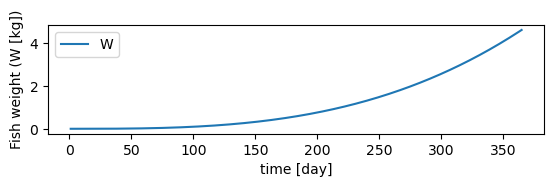

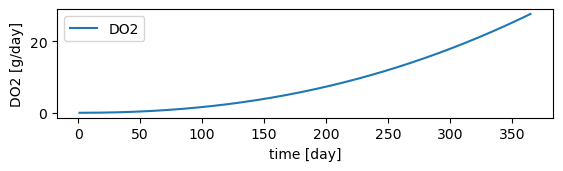

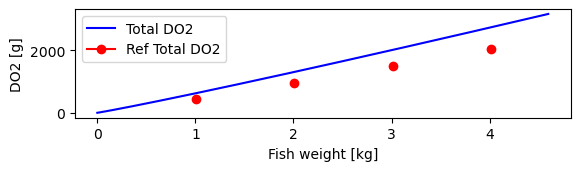

DO2 for 1kg fish 592.658417961274
DO2 for 2kg fish 1267.6196206239329
DO2 for 3kg fish 1968.158657940374
DO2 for 4kg fish 2690.091351663788
fish weight after 365 days 4597.867265255341


In [10]:
aqua_opt_obj = Aqua_Obj(res.x, x_name, p) 
aqua_opt_obj.plot_variable()

# Plot objective function and constraints

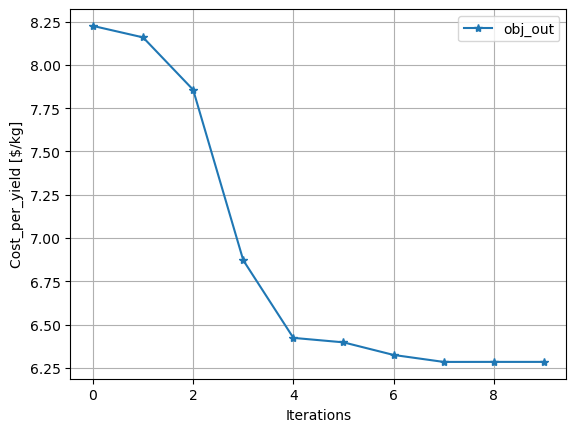

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(op_obj.f, label='obj_out', marker='*')
ax.set(xlabel='Iterations', ylabel='Cost_per_yield [$/kg]')
ax.legend()
ax.grid(True)
plt.show()

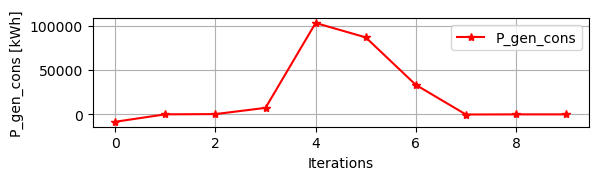

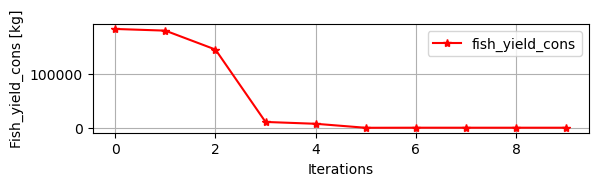

In [12]:
ax1 = plt.subplot(3,1,1)
ax1.plot(op_obj.ineq[:, 0], 'r', label='P_gen_cons', marker='*')
ax1.set(xlabel='Iterations', ylabel='P_gen_cons [kWh]');
ax1.legend()
ax1.grid(True)
plt.show()

ax2 = plt.subplot(3,1,2)
ax2.plot(op_obj.ineq[:, 1], 'r', label='fish_yield_cons', marker='*')
ax2.set(xlabel='Iterations', ylabel='Fish_yield_cons [kg]');
ax2.legend()
ax2.grid(True)
plt.show()
